## ResNet50 CNN transfer learning, audio files as spectrograms

**Results**: ~45% accuracy

**Conclusion**: Finally some acceptable results. It seems like the previous approaches were models that were unable to extract features from the audio files, and ResNet50's performance is the minimum needed.

**Next**: Find more models with pretrained weights for transfer learning, ideally with the same amount or fewer trainable parameters than ResNet50 but same or better performance.

In [8]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from IPython.display import Audio
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import torch.nn.functional as F
from tqdm import tqdm

import random
import glob
import os
import time

import sys
sys.path.append("..")
import utils

In [9]:
RANDOM_SEED = 21

# Set seed for experiment reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [10]:
is_in_kaggle_env = utils.get_is_in_kaggle_env()

data_path = '/kaggle/input/birdclef-2023/' if is_in_kaggle_env else '../data/'

device = 'cpu' if is_in_kaggle_env else utils.determine_device()

if not is_in_kaggle_env and not os.path.exists('../data'):
    print("Downloading data...")
    !kaggle competitions download -c 'birdclef-2023'
    !mkdir ../data
    !unzip -q birdclef-2023.zip -d ../data
    !rm birdclef-2023.zip

df_metadata_csv = pd.read_csv(f"{data_path}/train_metadata.csv")

audio_data_dir = f"{data_path}/train_audio/"

We are running code on Localhost
We are using device: mps


In [11]:
class_counts = df_metadata_csv["primary_label"].value_counts()

two_or_less_samples_rows = df_metadata_csv[df_metadata_csv["primary_label"].isin(class_counts[class_counts < 3].index)]

print(f"Number of unique classes with less than 2 samples: {len(two_or_less_samples_rows['primary_label'].unique())}")
print(f"Number of rows with less than 2 samples: {len(two_or_less_samples_rows)}")
print(f"Primary labels with less than 2 samples: {two_or_less_samples_rows['primary_label'].unique()}")

Number of unique classes with less than 2 samples: 10
Number of rows with less than 2 samples: 13
Primary labels with less than 2 samples: ['afpkin1' 'brcwea1' 'brtcha1' 'crefra2' 'golher1' 'lotcor1' 'rehblu1'
 'whctur2' 'whhsaw1' 'yebsto1']


In [12]:
# Drop rows with primary_label that have two or less samples
print(f"Number of rows before dropping: {len(df_metadata_csv)}")
df_metadata_csv = df_metadata_csv[~df_metadata_csv["primary_label"].isin(class_counts[class_counts < 3].index)]
print(f"Number of rows after dropping: {len(df_metadata_csv)}")

Number of rows before dropping: 16941
Number of rows after dropping: 16928


In [13]:
unique_classes = df_metadata_csv.primary_label.unique()
print(f"Number of classes: {len(unique_classes)}")

Number of classes: 254


In [14]:
log_dims = False
plot_spectrograms = False

class BirdClef23Dataset(Dataset):
    def __init__(self, df, audio_data_dir, label_encoder, seconds, n_mels=128):
        self.df = df
        self.audio_data_dir = audio_data_dir
        self.label_encoder = label_encoder
        self.seconds = seconds
        self.n_mels = n_mels

    def __getitem__(self, index):
        audio_path = os.path.join(self.audio_data_dir, self.df.iloc[index, 11])
        audio_numpy, audio_sr = librosa.load(audio_path, sr=32000)

        if audio_sr != 32000:
            raise ValueError(f"Sample rate is not 32000, it is {audio_sr} for {audio_path}")

        log_dims and print(f"audio_numpy dims 0: {audio_numpy.shape}")

        # Increase audio length if below {seconds}
        if audio_numpy.shape[0] < 32000 * self.seconds:
            log_dims and print(f"Padding audio from {audio_numpy.shape[0]} to {32000 * self.seconds}")

            padding_needed = int(32000 * self.seconds - audio_numpy.shape[0])
            
            pad_width = (0, padding_needed)
            
            audio_numpy = np.pad(audio_numpy, pad_width, 'wrap')

        # Truncate audio length if above {seconds}
        if audio_numpy.shape[0] > 32000 * self.seconds:
            log_dims and print(f"Truncating audio from {audio_numpy.shape[0]} to {32000 * self.seconds}")

            audio_numpy = audio_numpy[:32000 * self.seconds]

        log_dims and print(f"audio_numpy dims 1: {audio_numpy.shape}")

        # What is a mel-scaled spectrogram? https://www.youtube.com/watch?v=PYlr8ayHb4g
        # Compute mel-scaled spectrogram and convert to log scale (dB) https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_numpy, sr=audio_sr, n_mels=self.n_mels)
        log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)
        log_mel_spectrogram_norm = utils.normalize_spectrogram(log_mel_spectrogram)

        if plot_spectrograms:
            print(f"Mel-scaled spectrogram shape: {mel_spectrogram.shape}")
            librosa.display.specshow(log_mel_spectrogram_norm, y_axis='mel', fmax=8000, x_axis='time')
            plt.colorbar(format='%+2.0f dB')
            plt.tight_layout()
            plt.show()
        
        audio_numpy = log_mel_spectrogram_norm.reshape((1, log_mel_spectrogram_norm.shape[0], log_mel_spectrogram_norm.shape[1]))
        
        audio_tensor = torch.from_numpy(audio_numpy).float().to(device)

        primary_label_raw = self.df.iloc[index, 0]
        primary_label = self.label_encoder.transform([primary_label_raw])[0]

        row_id = audio_path.split('/')[-1].split('.')[0]

        return row_id, audio_tensor, primary_label
    
    def __len__(self):
        return len(self.df)


def get_data_loader(dataset, batch_size=32, data_percentage=None, shuffle=False, pin_memory=False):
    if data_percentage is not None:
        data_len = int(len(dataset) * data_percentage)
        dataset, _ = random_split(dataset, [data_len, len(dataset) - data_len])

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

    return data_loader


def split_df(df, primary_label='primary_label', percentages=[60, 20, 20]):
    """
    - Percentages: [train, valid, test]
    - Splits a dataframe into three dataframes (train, valid, test), stratified by primary_label
    - Also returns the class weights (based on the training set)
    """
    print(f"Splitting dataframe into train {percentages[0]}%, valid {percentages[1]}%, test {percentages[2]}%, stratified by {primary_label}")
    
    train_perc, valid_perc, test_perc = [perc / 100 for perc in percentages]
    train_valid_split = round(train_perc / (train_perc + valid_perc), 2)
    
    temp_df, test_df = train_test_split(df, test_size=test_perc, stratify=df[primary_label], random_state=RANDOM_SEED)
    
    train_df, valid_df = train_test_split(temp_df, test_size=1-train_valid_split, stratify=temp_df[primary_label], random_state=RANDOM_SEED)

    classes = np.unique(train_df[primary_label])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df[primary_label])

    return train_df, valid_df, test_df, class_weights


class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

       # https://pytorch.org/vision/stable/models.html
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 1 channel input instead of 3
        
        # fine tune the resnet classifier
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, num_classes),
        )

        self.softmax = nn.Softmax(dim=1)
 
    def forward(self, x):
        logits = self.resnet(x)
        probas = self.softmax(logits)

        return logits, probas


def train(model, train_loader, valid_loader, loss_func, optimizer, num_epochs, validate_on_train):
    minibatch_loss, train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst = [], [], [], [], []
    
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        
        # use tqdm to show progress bar
        for row_id, audio_tensor, primary_label in tqdm(train_loader, total=len(train_loader), desc="Training batches"):

            features = audio_tensor.to(device)
            targets = primary_label.to(device)

            log_dims and print(f"Input tensor shape: {audio_tensor.shape}")
            logits, probas = model(features)

            loss = loss_func(logits, targets)

            optimizer.zero_grad()
            
            loss.backward()

            minibatch_loss.append(loss.item())
            
            optimizer.step()
            
        train_acc, train_loss = validate(model, train_loader, loss_func) if validate_on_train else (torch.tensor(0.0), torch.tensor(0.0))
        train_acc_lst.append(train_acc)
        train_loss_lst.append(train_loss)

        valid_acc, valid_loss = validate(model, valid_loader, loss_func)
        valid_acc_lst.append(valid_acc)
        valid_loss_lst.append(valid_loss)

        print(f"Finsished epoch {epoch+1}/{num_epochs}. Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Valid Accuracy: {valid_acc:.2f}%")
              
    return minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst


def validate(model, data_loader, loss_fn=F.cross_entropy):
    model.eval()
    
    num_examples, correct_pred, cross_entropy = 0.0, 0.0, 0.0

    with torch.no_grad():
        for row_id, audio_tensor, primary_label in tqdm(data_loader, total=len(data_loader), desc='Validation batches'):
            features = audio_tensor.to(device)
            targets = primary_label.to(device)

            logits, probas = model(features)
            cross_entropy += loss_fn(logits, targets)

            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)

            correct_pred += (predicted_labels == targets).sum()

    accuracy = correct_pred / num_examples * 100
    loss = cross_entropy / num_examples
    return accuracy, loss


# --- training
ignore_existing_label_encoder = True
if ignore_existing_label_encoder or not os.path.exists('label_encoder.joblib'):
    print('Creating label encoder...')
    label_encoder = LabelEncoder()
    label_encoder.fit(list(unique_classes))
    joblib.dump(label_encoder, 'label_encoder.joblib')
else:
    print('Loading label encoder...')
    label_encoder = joblib.load('label_encoder.joblib')

train_df, valid_df, test_df, class_weights = split_df(df_metadata_csv)

seconds = 24 # 24 is the median
batch_size = 8
data_percentage = 1 # 1 means 100% of the data
num_epochs = 5
n_mels = 128 # 128 is the default value in librosa
learning_rate = 0.0001
pin_memory = True # https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723/6
validate_on_train = False

train_dataset = BirdClef23Dataset(train_df, audio_data_dir, label_encoder, seconds, n_mels)
valid_dataset = BirdClef23Dataset(valid_df, audio_data_dir, label_encoder, seconds, n_mels)
test_dataset = BirdClef23Dataset(test_df, audio_data_dir, label_encoder, seconds, n_mels)

print(f"Using {data_percentage * 100}% of the dataset")
train_loader = get_data_loader(train_dataset, batch_size, data_percentage, shuffle=True, pin_memory=pin_memory)
valid_loader = get_data_loader(valid_dataset, batch_size, data_percentage, shuffle=False, pin_memory=pin_memory)
test_loader = get_data_loader(test_dataset, batch_size, data_percentage, shuffle=False, pin_memory=pin_memory)

model = CNN(num_classes=len(unique_classes)).to(device)
print(f"Initialized model {model._get_name()}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

loss_function = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float().to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(model, train_loader, valid_loader, loss_function, optimizer, num_epochs, validate_on_train)

Creating label encoder...
Splitting dataframe into train 60%, valid 20%, test 20%, stratified by primary_label
Using 100% of the dataset
Initialized model CNN
Trainable parameters: 26255038
Starting epoch 1/5


Validation batches: 100%|██████████| 424/424 [03:03<00:00,  2.31it/s]


Finsished epoch 1/5. Train Loss: 0.0000, Valid Loss: 0.5718, Train Accuracy: 0.00%, Valid Accuracy: 17.40%
Starting epoch 2/5


Validation batches: 100%|██████████| 424/424 [03:05<00:00,  2.28it/s]


Finsished epoch 2/5. Train Loss: 0.0000, Valid Loss: 0.4814, Train Accuracy: 0.00%, Valid Accuracy: 27.64%
Starting epoch 3/5


Validation batches: 100%|██████████| 424/424 [03:11<00:00,  2.21it/s]


Finsished epoch 3/5. Train Loss: 0.0000, Valid Loss: 0.4161, Train Accuracy: 0.00%, Valid Accuracy: 42.56%
Starting epoch 4/5


Validation batches: 100%|██████████| 424/424 [03:13<00:00,  2.19it/s]


Finsished epoch 4/5. Train Loss: 0.0000, Valid Loss: 0.3973, Train Accuracy: 0.00%, Valid Accuracy: 43.03%
Starting epoch 5/5


Validation batches: 100%|██████████| 424/424 [03:04<00:00,  2.30it/s]


Finsished epoch 5/5. Train Loss: 0.0000, Valid Loss: 0.4197, Train Accuracy: 0.00%, Valid Accuracy: 45.84%


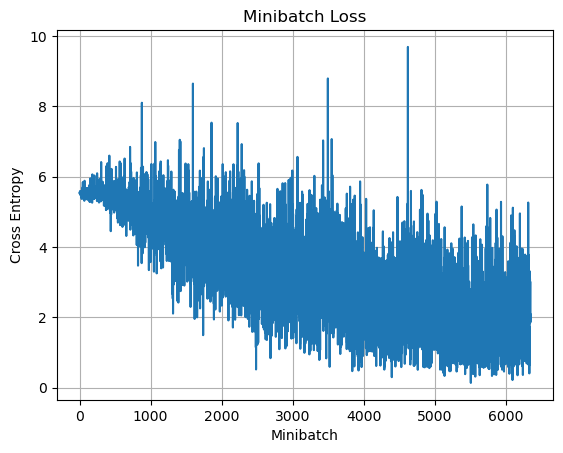

In [15]:
utils.plot_minibatch_loss(minibatch_loss)

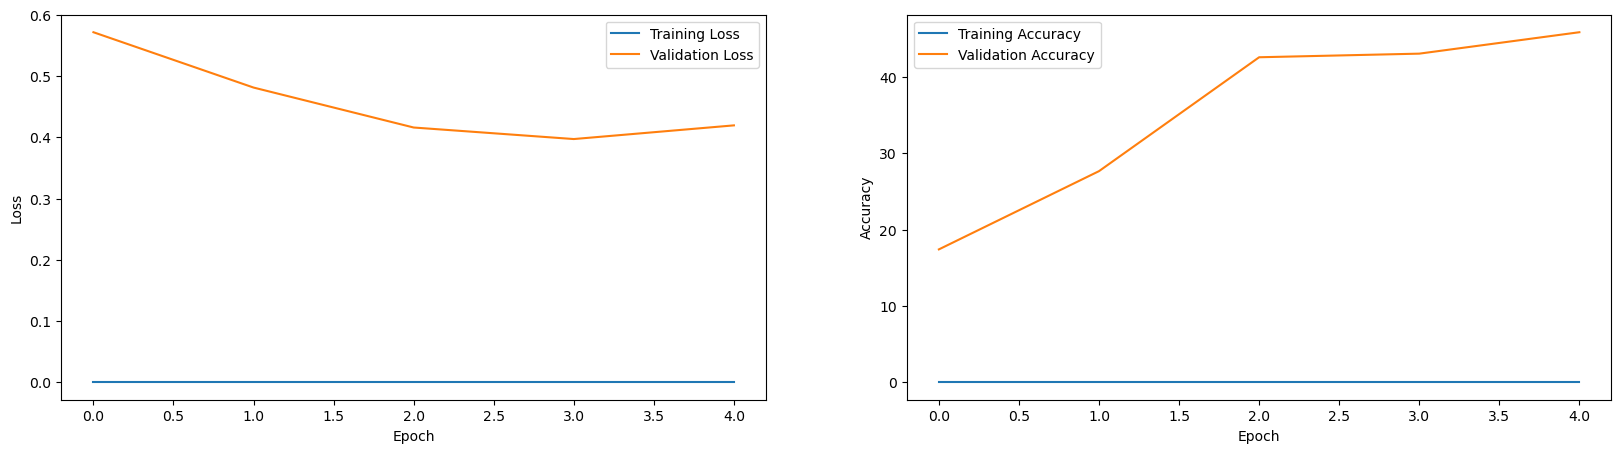

In [16]:
utils.plot_train_and_valid_loss_and_accuracy(train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst)